<a href="https://colab.research.google.com/github/rgrion/mlarrozprevisao/blob/main/Experimentos_Preliminares/Treinamento_Rice_South_America_2014_a_2018_5anos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Lista de anos e dicionário para armazenar
anos = list(range(2014, 2024))
dados_por_ano = {}

for ano in anos:
    df = pd.read_csv(f'/content/Rice_{ano}.csv')
    df = df[['Area', 'Year', 'Production (t)', 'Area harvested (ha)', 'Yield (kg/ha)']].dropna()
    df = df[df['Area'] != 'South America']  # Remover o total agregado
    dados_por_ano[ano] = df

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler

resultados = []

# Dataset de treino
df_treino = pd.concat([
    dados_por_ano[2014], dados_por_ano[2015], dados_por_ano[2016], dados_por_ano[2017], dados_por_ano[2018]
])
paises = df_treino['Area'].unique()

# Loop de previsão
for ano in range(2019, 2024):
    df_real = dados_por_ano[ano]

    for pais in paises:
        try:
            df_pais_treino = df_treino[df_treino['Area'] == pais]
            df_pais_real = df_real[df_real['Area'] == pais]

            if len(df_pais_treino) < 2 or df_pais_real.empty:
                continue

            # Dados de treino e predição
            X_train = df_pais_treino[['Year', 'Area harvested (ha)']]
            y_train = df_pais_treino['Production (t)']

            area_pred = df_pais_real['Area harvested (ha)'].values[0]
            X_pred = pd.DataFrame({'Year': [ano], 'Area harvested (ha)': [area_pred]})

            # Treinamento dos modelos
            lr = LinearRegression().fit(X_train, y_train)
            xgb = XGBRegressor(objective='reg:squarederror', n_estimators=50).fit(X_train, y_train)

            # Normalização para SVR
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_pred_scaled = scaler.transform(X_pred)

            svr = SVR(kernel='rbf', C=100, gamma=0.1).fit(X_train_scaled, y_train)

            # Previsões
            pred_lr = lr.predict(X_pred)[0]
            pred_xgb = xgb.predict(X_pred)[0]
            pred_svr = svr.predict(X_pred_scaled)[0]

            prod_real = df_pais_real['Production (t)'].values[0]

            resultados.append({
                'Area': pais,
                'Ano_Previsto': ano,
                'Production_Real': prod_real,
                'Prod_LR': pred_lr,
                'Prod_XGB': pred_xgb,
                'Prod_SVR': pred_svr
            })

        except Exception as e:
            print(f'Erro com país {pais} no ano {ano}: {e}')

In [ ]:
# Converter a lista em DataFrame
df_resultado = pd.DataFrame(resultados)

# Calcular erros absolutos e percentuais para cada modelo
for modelo in ['LR', 'XGB', 'SVR']:
    df_resultado[f'Erro_Abs_Prod_{modelo}'] = abs(df_resultado[f'Prod_{modelo}'] - df_resultado['Production_Real'])
    df_resultado[f'Erro_%_Prod_{modelo}'] = 100 * df_resultado[f'Erro_Abs_Prod_{modelo}'] / df_resultado['Production_Real']

# Definir formato com duas casas decimais
pd.set_option('display.float_format', '{:,.2f}'.format)

# Exibir tabela ordenada por país e ano
display(df_resultado[['Area', 'Ano_Previsto',
                      'Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR',
                      'Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']]
        .sort_values(by=['Area', 'Ano_Previsto'])
        .round(2))

,Area,Ano_Previsto,Production_Real,Prod_LR,Prod_XGB,Prod_SVR,Erro_%_Prod_LR,Erro_%_Prod_XGB,Erro_%_Prod_SVR
0,Argentina,2019,"1,189,866.00","1,262,349.33","1,367,974.12","1,404,891.67",6.09,14.97,18.07
12,Argentina,2020,"1,222,910.00","1,289,697.48","1,367,974.12","1,404,906.98",5.46,11.86,14.88
24,Argentina,2021,"1,453,187.00","1,402,137.73","1,367,974.12","1,404,930.02",3.51,5.86,3.32
36,Argentina,2022,"1,222,426.00","1,322,513.35","1,367,974.12","1,404,959.07",8.19,11.91,14.93
48,Argentina,2023,"1,163,209.00","1,248,627.54","1,367,974.12","1,404,988.26",7.34,17.60,20.79
1,Bolivia (Plurinational State of),2019,"600,044.00","581,792.30","498,254.72","484,051.73",3.04,16.96,19.33
13,Bolivia (Plurinational State of),2020,"487,427.00","547,330.39","498,254.72","484,060.70",12.29,2.22,0.69
25,Bolivia (Plurinational State of),2021,"550,181.52","564,187.26","498,254.72","484,060.83",2.55,9.44,12.02
37,Bolivia (Plurinational State of),2022,"608,680.66","668,905.80","498,254.72","484,059.04",9.89,18.14,20.47
49,Bolivia (Plurinational State of),2023,"698,543.58","696,746.86","498,254.72","484,059.09",0.26,28.67,30.70


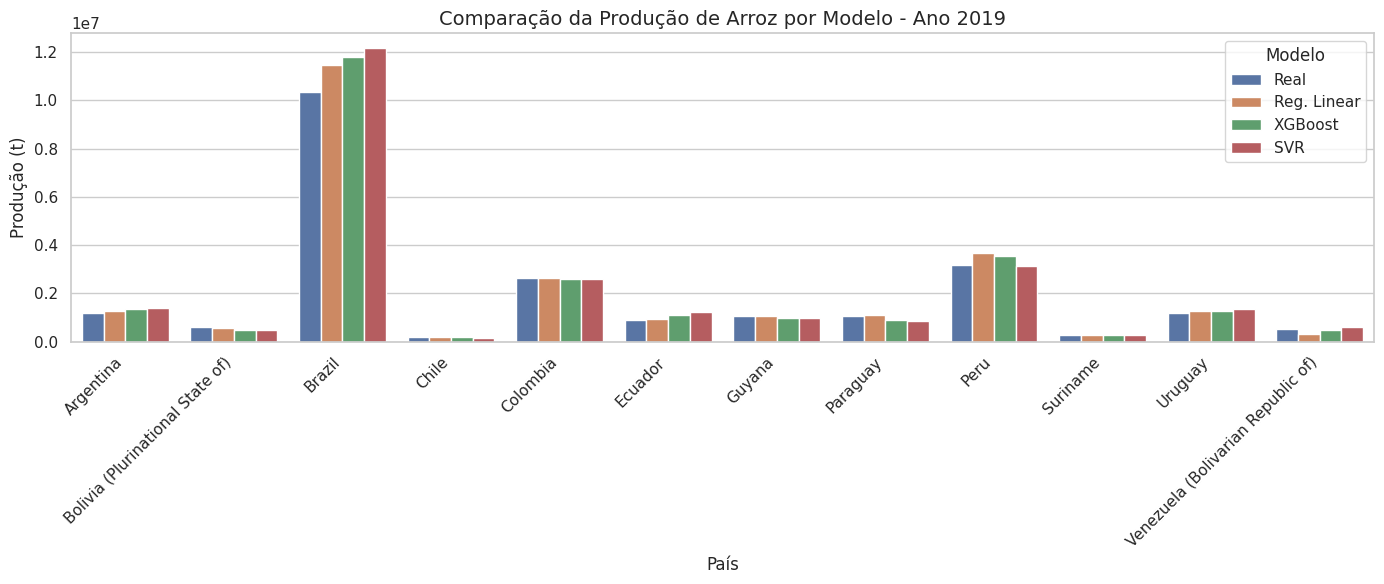

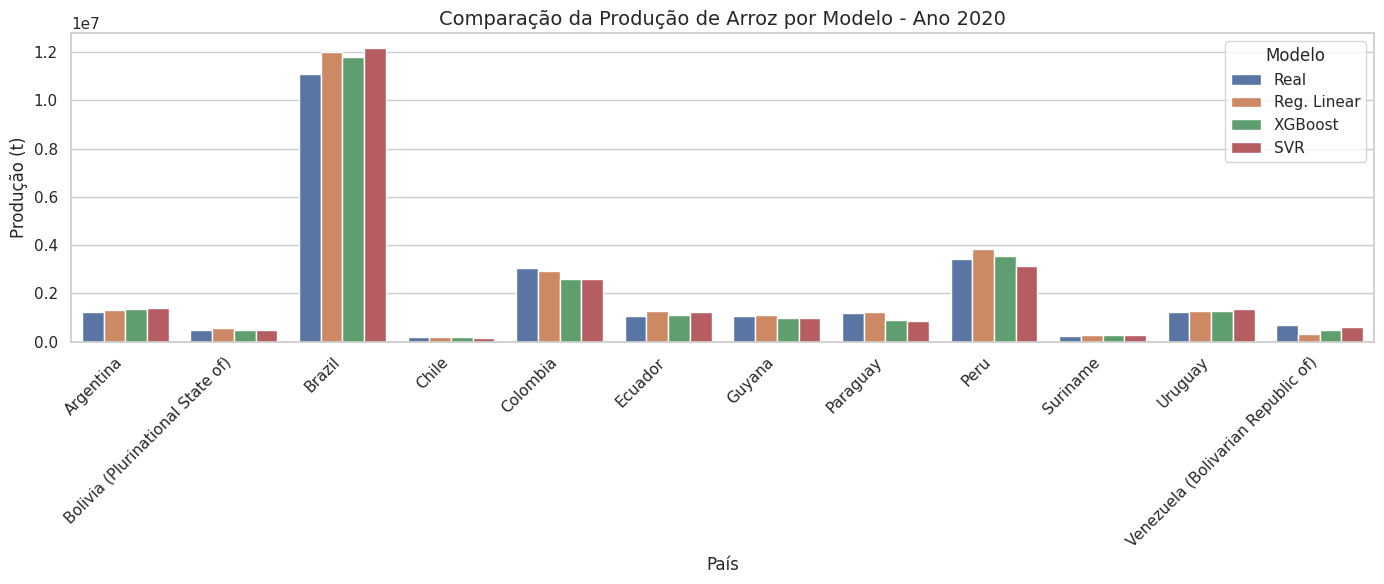

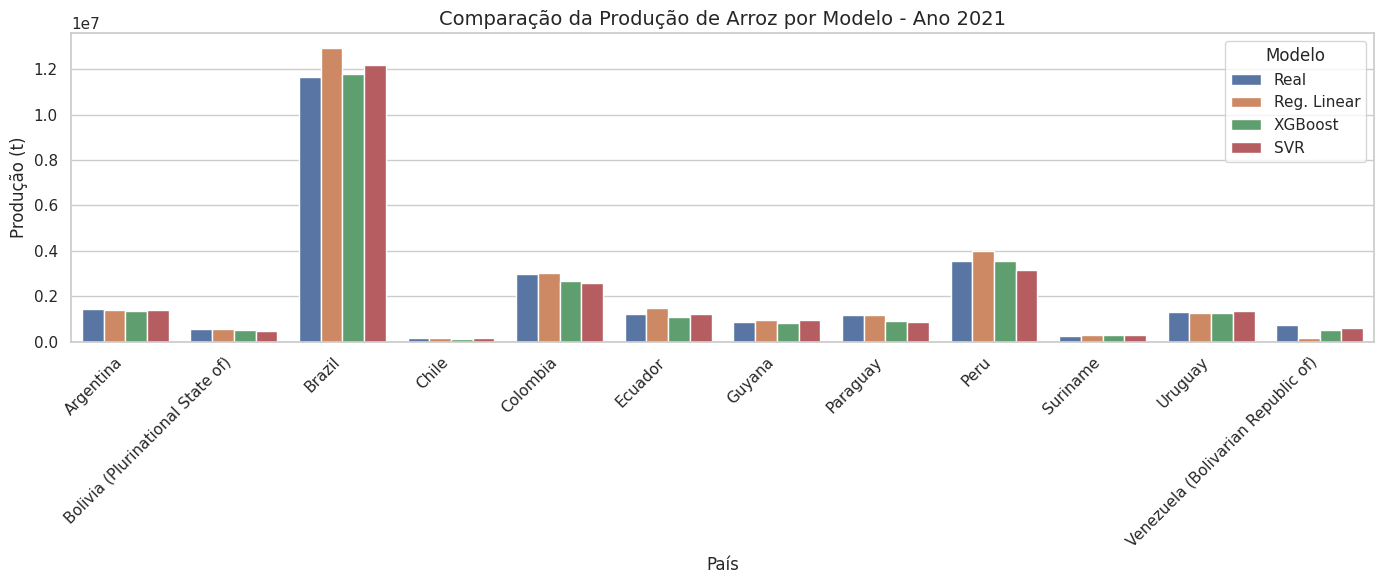

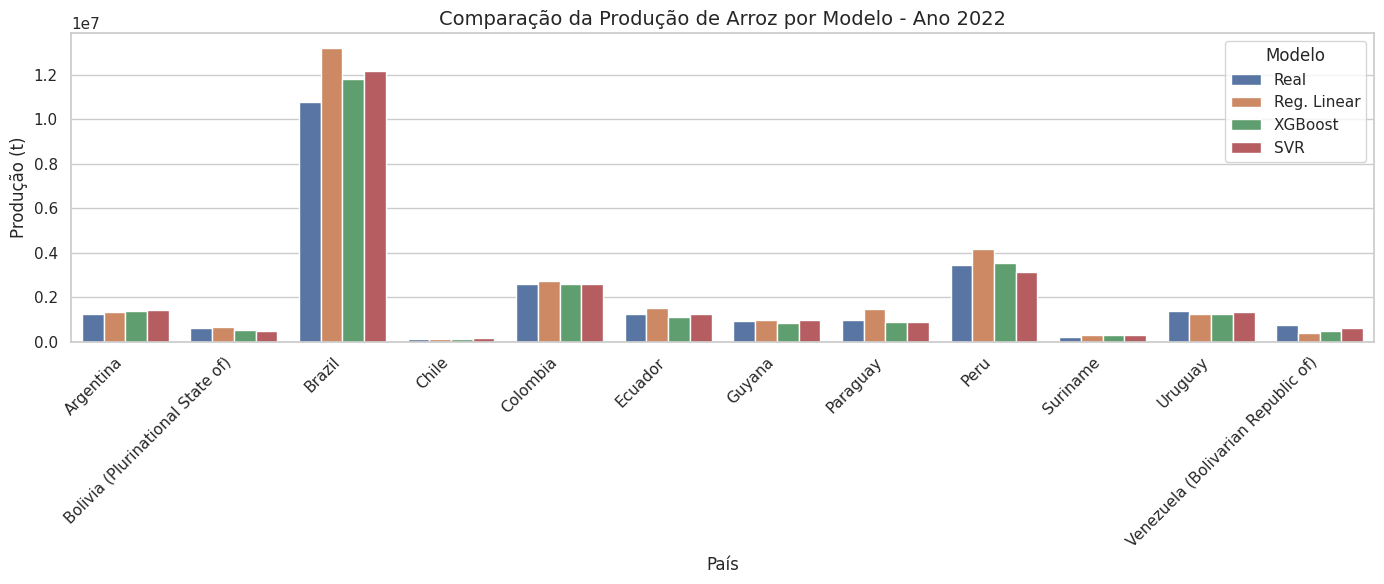

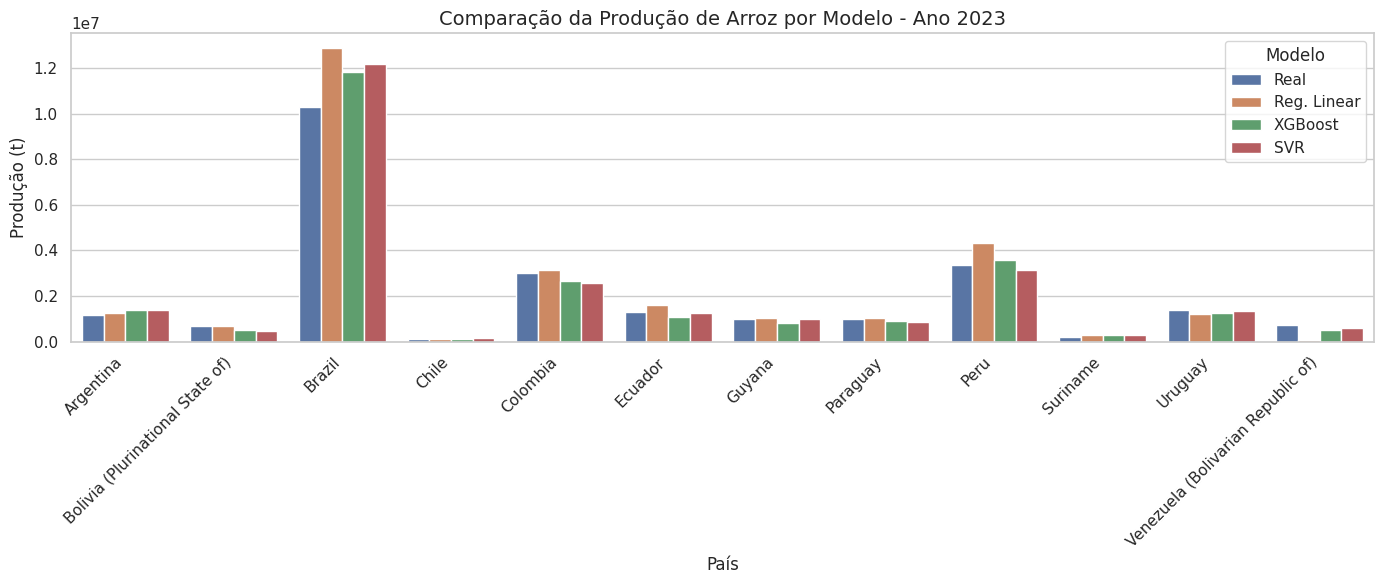

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Garantir estilo bonito
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Loop para um gráfico por ano
anos_previstos = sorted(df_resultado['Ano_Previsto'].unique())

for ano in anos_previstos:
    df_ano = df_resultado[df_resultado['Ano_Previsto'] == ano].copy()

    # Reformata para gráfico de barras agrupadas
    df_plot = pd.melt(df_ano,
                      id_vars='Area',
                      value_vars=['Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR'],
                      var_name='Modelo',
                      value_name='Produção')

    # Renomear para legenda mais limpa
    df_plot['Modelo'] = df_plot['Modelo'].replace({
        'Production_Real': 'Real',
        'Prod_LR': 'Reg. Linear',
        'Prod_XGB': 'XGBoost',
        'Prod_SVR': 'SVR'
    })

    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=df_plot, x='Area', y='Produção', hue='Modelo')
    plt.title(f'Comparação da Produção de Arroz por Modelo - Ano {ano}', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Produção (t)')
    plt.xlabel('País')
    plt.legend(title='Modelo')
    plt.tight_layout()
    plt.show()

In [ ]:
media_por_ano = df_resultado.groupby('Ano_Previsto')[
    ['Production_Real', 'Prod_LR', 'Prod_XGB', 'Prod_SVR']
].mean().reset_index()


media_erro_por_ano = df_resultado.groupby('Ano_Previsto')[
    ['Erro_%_Prod_LR', 'Erro_%_Prod_XGB', 'Erro_%_Prod_SVR']
].mean().reset_index()

print("Média da produção e previsões por ano:")
print(media_por_ano)

print("\nMédia dos erros percentuais por ano:")
print(media_erro_por_ano)

Média da produção e previsões por ano:
   Ano_Previsto  Production_Real      Prod_LR     Prod_XGB     Prod_SVR
0          2019     1,929,677.81 2,060,259.78 2,082,139.50 2,103,522.52
1          2020     2,077,073.25 2,188,749.81 2,080,847.00 2,103,521.05
2          2021     2,155,520.93 2,278,898.32 2,068,641.88 2,103,518.28
3          2022     2,018,670.75 2,334,179.95 2,063,623.38 2,103,520.56
4          2023     2,017,919.87 2,302,057.71 2,068,641.88 2,103,525.96

Média dos erros percentuais por ano:
   Ano_Previsto  Erro_%_Prod_LR  Erro_%_Prod_XGB  Erro_%_Prod_SVR
0          2019            8.46            10.93            13.17
1          2020           12.42            10.85            11.76
2          2021           13.41             9.97            10.27
3          2022           22.90            16.37            17.55
4          2023           20.85            17.92            18.08


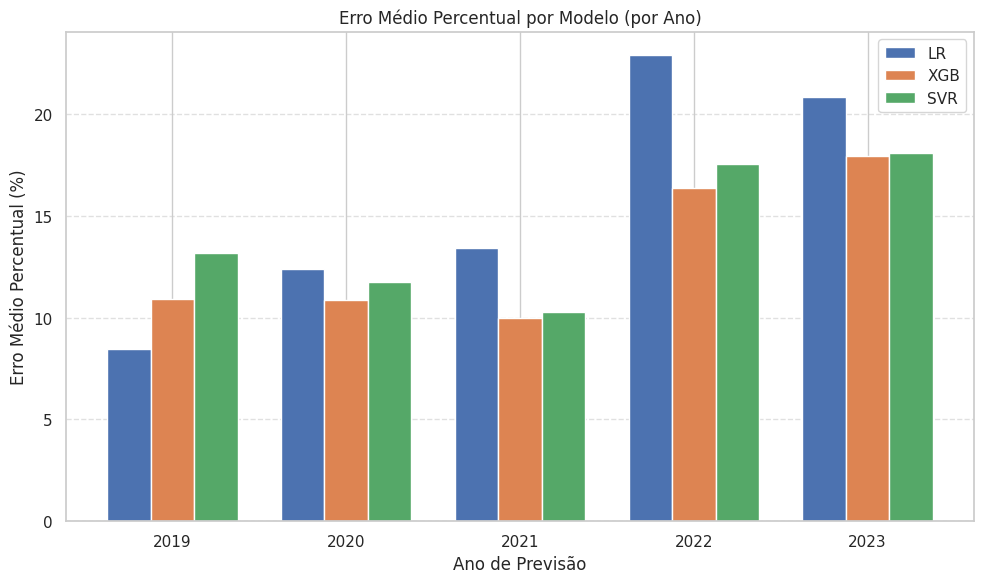

In [ ]:
import matplotlib.pyplot as plt

# Supondo que você já tenha o DataFrame `media_erro_por_ano`
plt.figure(figsize=(10, 6))

# Plotando as barras lado a lado por modelo
largura = 0.25
anos = media_erro_por_ano['Ano_Previsto']
x = range(len(anos))

plt.bar([p - largura for p in x], media_erro_por_ano['Erro_%_Prod_LR'], width=largura, label='LR')
plt.bar(x, media_erro_por_ano['Erro_%_Prod_XGB'], width=largura, label='XGB')
plt.bar([p + largura for p in x], media_erro_por_ano['Erro_%_Prod_SVR'], width=largura, label='SVR')

# Eixos e rótulos
plt.xticks(x, anos)
plt.ylabel('Erro Médio Percentual (%)')
plt.xlabel('Ano de Previsão')
plt.title('Erro Médio Percentual por Modelo (por Ano)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()